# Introduction:
## Generation of Iceberg Catalog for Parquet files

In [1]:
import pyarrow as pa
import pyiceberg
from pyiceberg.catalog import load_catalog
from pyiceberg.schema import Schema
from pyiceberg.types import NestedField, IntegerType, StringType, DoubleType, LongType, BinaryType, BooleanType
from pyiceberg.expressions import EqualTo, LessThan, And, GreaterThan, GreaterThanOrEqual
import pyarrow.parquet as pq
from pyiceberg.schema import Schema
import boto3
import s3fs
import re
import os
import warnings
warnings.filterwarnings('ignore')

class IcebergTable(object):
    '''
    Create a Iceberg table per parquet file w/ its inherited schema set.

    Note: It is okay to expect following warning statements throughout process:
    "Iceberg does not have a dictionary type. <class 'pyarrow.lib.DictionaryType'> will be inferred as string on read."
    
    '''
    def __init__(self):

        # Generate folder for iceberg catalog
        if not os.path.exists(f'{os.getcwd()}/iceberg_catalog'):
            os.makedirs(f'{os.getcwd()}/iceberg_catalog')

        # Set location of where the iceberg catalog will reside
        os.environ['PYICEBERG_HOME'] = os.getcwd()

        # Initialize namespace to be set for Iceberg catalog
        self.namespace = str()
    
    def read_data_dirs(self, data_dir):
        '''
        Extract the list of parquet directories.
        
        Args:
            data_dir (str): Parent directory of the parquet files.
                            Note: All the ml_auxiliary_data parquet 
                            files are save under same filenames, 
                            but categorized by 'vpuid' conditions.

        Return (list): List of directories associated with each parquet file.
        
        '''
        parquet_list = []
        for folder, subfolders, files in os.walk(data_dir):
            if folder != data_dir:
                for file in files:
                    parquet_list.append(f'{folder}/{file}')
                    
        return parquet_list
        
    def read_data(self, parquet_file_path):
        '''
        Load a single parquet as a Pyarrow table.
        
        Args: 
            parquet_file_path (str): Directory of a single parquet.

    
        Return: A Pyarrow table.
        
        '''
        data = pq.read_table(parquet_file_path)
        
        return data

    def establish_catalog(self, catalog_name, namespace):
        '''
        Creates a new Iceberg catalog.
        
        Args:
            catalog_name (str): Name of the catalog to be created.
                                Default: 'dev' for development catalog
            namespace (str): Name of namespace.

        Return: None
        
        ''' 
        # Establish a new Iceberg catalog & its configuration
        self.catalog = load_catalog(name=catalog_name,
                                    **{'uri': f'sqlite:///iceberg_catalog/{catalog_name}_catalog.db'})
        
        # Establish namespace to be create w/in catalog
        self.namespace = namespace
        if self.namespace not in self.catalog.list_namespaces():
            self.catalog.create_namespace(self.namespace)
        
        return

    def convert_pyarrow_to_iceberg_schema(self, arrow_schema):
        """
        Translate a given Pyarrow schema into a schema acceptable by Iceberg.

        Args:
            arrow_schema (object): Pyarrow schema read from the loaded 
                                   parquet of interest.

        Return (object): Iceberg schema
        
        """
        fields = []
        for idx in range(len(arrow_schema)):
            
            # Extraction of the datatype & name of each schema row
            field_name = arrow_schema.field(idx).name
            arrow_type = arrow_schema.field(idx).type

            # Iceberg datatypes to pyarrow datatypes
            if pa.types.is_int32(arrow_type):
                iceberg_type = LongType()
            elif pa.types.is_string(arrow_type):
                iceberg_type = StringType()
            elif pa.types.is_float64(arrow_type):
                iceberg_type = DoubleType()
            elif pa.types.is_int64(arrow_type):
                iceberg_type = LongType()
            elif pa.types.is_boolean(arrow_type):
                iceberg_type = BooleanType()
            elif pa.types.is_binary(arrow_type):
                iceberg_type = BinaryType()
            elif pa.types.is_dictionary(arrow_type): 
                if pa.types.is_string(arrow_type.value_type):
                    iceberg_type = StringType()
                elif pa.types.is_int32(arrow_type.value_type):
                    iceberg_type = LongType()
            else:
                raise ValueError(f"Unsupported PyArrow type: {arrow_type}")

            # Establish the new schema acceptable to Iceberg
            fields.append(NestedField(field_id=idx + 1,
                                      required=False,
                                      name=field_name,
                                      field_type=iceberg_type))
        # Iceberg schema
        schema = Schema(*fields)
        
        return schema

    def create_table_for_parquet(self, iceberg_tablename, data_table, schema):
        '''
        Convert parquet Pyarrow table to iceberg table & allocate Iceberg catalog under the ./iceberg_catalog directory.

        Args:
            iceberg_tablename (str): Name of the Iceberg table to be created.
            
            data_table (object): Pyarrow table
            
            schema (object): Unique Iceberg schema to be set for the Iceberg table.
            
            namespace (str): Namespace for which the Iceberg table will reside within
                             the Iceberg catalog.

        Return: None
        
        '''
        
        # Create an Iceberg table
        iceberg_table = self.catalog.create_table(identifier=f"{self.namespace}.{iceberg_tablename}",
                                                  schema=schema,
                                                  location=f"{os.environ['PYICEBERG_HOME']}/iceberg_catalog")
        
        # Updates the Iceberg table with data of interest.
        iceberg_table.append(data_table)
        
        return

    def create_table_for_all_parquets(self, parquet_files, app_name='mip-xs'):
        '''
        Convert parquets to Iceberg tables - each w/ their inherited schema.

        Args:
            parquet_files (list): List of directories of the parquet files.

            app_name (str): Application to create Iceberg tables.
                            Options: 'mip-xs' & 'bathymetry_ml_auxiliary'

        Return: None

        Note: The sourced data structures for the data in 'mip-xs' & 
        'bathymetry_ml_auxiliary' S3 buckets differ.
                
        '''
        for idx, parquet_file in enumerate(parquet_files):
            if app_name == 'mip_xs':
                iceberg_tablename = f"{os.path.split(os.path.split(parquet_file)[1])[1].split('.')[0]}"
            
            elif app_name == 'bathymetry_ml_auxiliary':
                iceberg_tablename = f"{os.path.split(os.path.split(parquet_file)[0])[1]}"

            data_table = self.read_data(parquet_file)
            data_pyarrow_schema = data_table.schema
            schema = self.convert_pyarrow_to_iceberg_schema(data_pyarrow_schema)
            self.create_table_for_parquet(iceberg_tablename,
                                          data_table, 
                                          schema)
        return

    def create_table_for_all_s3parquets(self, app_name, bucket_name, profile_name='default'):
        '''
        Convert parquets from S3 to Iceberg tables - each w/ their inherited schema.
    
        Args:
            bucket_name (list): S3 bucket name.

            app_name (str): Application to create Iceberg tables.
                            Options: 'mip_xs' & 'bathymetry_ml_auxiliary'
            
            namespace (str): Namespace for which the Iceberg table will reside within
                             the Iceberg catalog.

            profile_name (str: Profile name declared in the AWS configuration file. 
                               Default: 'default' 
    
        Return: None

        '''
        # Instantiate bucket of interest.
        session = boto3.Session(profile_name=profile_name)
        s3 = session.resource('s3')
        bucket_ob = s3.Bucket(bucket_name)
        pyarrow_table = {}
        for s3obj in bucket_ob.objects.all():

            # For sourcing the preprocessed XS parquets from S3
            if app_name == 'mip_xs' and re.match(r'^xs_data/.*\.parquet$', s3obj.key):
                iceberg_tablename = f"{os.path.split(os.path.split(s3obj.key)[1])[1].split('.')[0]}"
                pyarrow_table[iceberg_tablename]= pq.read_table(f's3://{bucket_name}/{s3obj.key}',
                                        filesystem=s3fs.S3FileSystem())
                
            # For sourcing the bathymetry_ml_auxiliary parquets from S3
            elif app_name == 'bathymetry_ml_auxiliary':
                iceberg_tablename = f"{os.path.split(os.path.split(s3obj.key)[0])[1]}"
                pyarrow_table[iceberg_tablename]= pq.read_table(f's3://{bucket_name}/{s3obj.key}',
                                        filesystem=s3fs.S3FileSystem())
                
        # Xforming each unique parquet to an iceberg table    
        for key, data_table in pyarrow_table.items():
            data_pyarrow_schema = data_table.schema
            schema = self.convert_pyarrow_to_iceberg_schema(data_pyarrow_schema)
            self.create_table_for_parquet(key,
                                          data_table, 
                                          schema)
        return

#### Demo:
#### Establish A New Iceberg Catalog & Generate Tables For All Parquets in Local

In [2]:
# Scenario I
# Instantiate class
obj = IcebergTable()

# Extract list of parquets
parquet_list = obj.read_data_dirs(data_dir=f'{os.getcwd()}/data/bathymetry/ml_auxiliary_data/')

# Establish new Iceberg catalog
obj.establish_catalog(catalog_name='bathymetry_ml_auxiliary_dev',
                      namespace='bathymetry_ml_auxiliary')

# Generate tables w/in the new Iceberg catalog for all parquets detected 
obj.create_table_for_all_parquets(parquet_list, 
                                  app_name='bathymetry_ml_auxiliary')

Iceberg does not have a dictionary type. <class 'pyarrow.lib.DictionaryType'> will be inferred as int32 on read.
Iceberg does not have a dictionary type. <class 'pyarrow.lib.DictionaryType'> will be inferred as int32 on read.
Iceberg does not have a dictionary type. <class 'pyarrow.lib.DictionaryType'> will be inferred as int32 on read.
Iceberg does not have a dictionary type. <class 'pyarrow.lib.DictionaryType'> will be inferred as int32 on read.
Iceberg does not have a dictionary type. <class 'pyarrow.lib.DictionaryType'> will be inferred as int32 on read.
Iceberg does not have a dictionary type. <class 'pyarrow.lib.DictionaryType'> will be inferred as int32 on read.
Iceberg does not have a dictionary type. <class 'pyarrow.lib.DictionaryType'> will be inferred as int32 on read.
Iceberg does not have a dictionary type. <class 'pyarrow.lib.DictionaryType'> will be inferred as int32 on read.
Iceberg does not have a dictionary type. <class 'pyarrow.lib.DictionaryType'> will be inferred a

#### Demo
#### Establish A New Iceberg Catalog & Generate Tables For All Parquets in S3

In [3]:
# Scenario II
# Instantiate class
obj = IcebergTable()

# Establish new Iceberg catalog
obj.establish_catalog(catalog_name='bathymetry_ml_auxiliary_dev2',
                      namespace='bathymetry_ml_auxiliary')

# Generate tables w/in the new Iceberg catalog for all parquets detected in s3
obj.create_table_for_all_s3parquets(app_name='bathymetry_ml_auxiliary',
                                    bucket_name='ngwpc-bathymetry',
                                    profile_name='default')

Iceberg does not have a dictionary type. <class 'pyarrow.lib.DictionaryType'> will be inferred as int32 on read.
Iceberg does not have a dictionary type. <class 'pyarrow.lib.DictionaryType'> will be inferred as int32 on read.
Iceberg does not have a dictionary type. <class 'pyarrow.lib.DictionaryType'> will be inferred as int32 on read.
Iceberg does not have a dictionary type. <class 'pyarrow.lib.DictionaryType'> will be inferred as int32 on read.
Iceberg does not have a dictionary type. <class 'pyarrow.lib.DictionaryType'> will be inferred as int32 on read.
Iceberg does not have a dictionary type. <class 'pyarrow.lib.DictionaryType'> will be inferred as int32 on read.
Iceberg does not have a dictionary type. <class 'pyarrow.lib.DictionaryType'> will be inferred as int32 on read.
Iceberg does not have a dictionary type. <class 'pyarrow.lib.DictionaryType'> will be inferred as int32 on read.
Iceberg does not have a dictionary type. <class 'pyarrow.lib.DictionaryType'> will be inferred a

In [4]:
# Scenario III
# Instantiate class
obj = IcebergTable()

# Establish new Iceberg catalog
obj.establish_catalog(catalog_name='xs',
                      namespace='mip')

# Generate tables w/in the new Iceberg catalog for all parquets detected in s3
obj.create_table_for_all_s3parquets(app_name='mip_xs',
                                    bucket_name='ngwpc-xs',
                                    profile_name='default')

#### Demo:
#### Load Iceberg Catalog & Table of Interest

In [11]:
# Load-in table from catalog of interest & observe the first N (e.g. 20) feature columns + schema
catalog_name = 'bathymetry_ml_auxiliary_dev'
namespace = 'bathymetry_ml_auxiliary'
tablename = 'vpuid=01'
catalog = load_catalog(name=catalog_name, 
                       **{'uri': f'sqlite:///iceberg_catalog/{catalog_name}_catalog.db'})
iceberg_table = catalog.load_table(f'{namespace}.{tablename}').scan().to_arrow()
print(iceberg_table.to_string(preview_cols=20))

pyarrow.Table
hf_source: large_string
owp_ahg_c: double
owp_ahg_f: double
owp_ahg_a: double
owp_ahg_b: double
owp_ahg_k: double
owp_ahg_m: double
owp_dingman_r: double
LENGTHKM: double
slope: double
owp_bf_channel_area: double
owp_inchan_channel_area: double
owp_bf_channel_perimeter: double
owp_inchan_channel_perimeter: double
owp_bf_channel_volume: double
owp_inchan_channel_volume: double
owp_bf_channel_bed_area: double
owp_inchan_channel_bed_area: double
owp_y_bf: double
owp_y_inchan: double
owp_tw_bf: double
owp_tw_inchan: double
owp_roughness_bathy: double
owp_roughness_bathy_lower_bound: double
owp_roughness_bathy_upper_bound: double
hf_id: int64
owp_roughness_no_bathy: double
hand_source: large_string
vpuid: int64
----
hf_source: [["reference_fabric","reference_fabric","reference_fabric","reference_fabric","reference_fabric",...,"reference_fabric","reference_fabric","reference_fabric","reference_fabric","reference_fabric"]]
owp_ahg_c: [[0.2783956527709961,0.26645627617836,0.27784

In [6]:
# Load-in table from catalog of interest & observe the first N (e.g. 20) feature columns + schema
catalog_name = 'bathymetry_ml_auxiliary_dev2'
namespace = 'bathymetry_ml_auxiliary'
tablename = 'vpuid=01'
catalog = load_catalog(name=catalog_name, 
                       **{'uri': f'sqlite:///iceberg_catalog/{catalog_name}_catalog.db'})
iceberg_table = catalog.load_table(f'{namespace}.{tablename}').scan().to_arrow()
#print(iceberg_table.to_string(preview_cols=20))

In [7]:
# Load-in table from catalog of interest & observe the first N (e.g. 20) feature columns + schema
catalog_name = 'xs'
namespace = 'mip'
tablename = 'huc_01020002'
catalog = load_catalog(name=catalog_name, 
                       **{'uri': f'sqlite:///iceberg_catalog/{catalog_name}_catalog.db'})
iceberg_table = catalog.load_table(f'{namespace}.{tablename}').scan().to_arrow()
print(iceberg_table.to_string(preview_cols=20))

pyarrow.Table
river: large_string
reach: large_string
river_reach: large_string
river_station: double
river_reach_rs: large_string
thalweg: double
xs_max_elevation: double
left_reach_length: double
right_reach_length: double
channel_reach_length: double
ras_data: large_string
station_elevation_points: large_string
bank_stations: large_string
number_of_station_elevation_points: int64
number_of_coords: int64
flows: large_string
profile_names: large_string
geometry: large_binary
huc: large_string
model_id: large_string
us_reach_id: large_string
us_network_to_id: large_string
ds_reach_id: large_string
ds_network_to_id: large_string
__index_level_0__: int64
----
river: [["Stream0528","Stream0528","Stream0528","Stream0528","Stream0528",...,"Stream0512","Stream0512","Stream0512","Stream0512","Stream0512"]]
reach: [["Reach-1","Reach-1","Reach-1","Reach-1","Reach-1",...,"Reach-1","Reach-1","Reach-1","Reach-1","Reach-1"]]
river_reach: [["Stream0528,Reach-1","Stream0528,Reach-1","Stream0528,Reach

#### Observe List of Tables under Catalog of Interest

In [8]:
# All tables created within the namespace of interest.
print(f"List of tables under {namespace} within {catalog_name}:\n\n{catalog.list_tables(namespace)}") 

List of tables under mip within xs:

[('mip', 'huc_01020002'), ('mip', 'huc_02060006'), ('mip', 'huc_03170004'), ('mip', 'huc_04030101'), ('mip', 'huc_05020006'), ('mip', 'huc_06040002'), ('mip', 'huc_07130010'), ('mip', 'huc_08060202'), ('mip', 'huc_09020301'), ('mip', 'huc_10120203'), ('mip', 'huc_11060002'), ('mip', 'huc_12030107'), ('mip', 'huc_13020102'), ('mip', 'huc_14050005'), ('mip', 'huc_15040007'), ('mip', 'huc_16020203'), ('mip', 'huc_17060305'), ('mip', 'huc_18070204')]


#### Query Iceberg Catalog's Table by Conditions (Note: Against the catalog_name = 'bathymetry_ml_auxiliary_dev')

In [12]:
# Filter Iceberg table based on threshold set for a given feature
namespace='bathymetry_ml_auxiliary'
tablename = 'vpuid=01'
feature_name = 'owp_ahg_c'
thresh_val = 0.25
catalog.load_table(f'{namespace}.{tablename}').scan(row_filter=LessThan(feature_name, thresh_val)).to_arrow()

pyarrow.Table
hf_source: large_string
owp_ahg_c: double
owp_ahg_f: double
owp_ahg_a: double
owp_ahg_b: double
owp_ahg_k: double
owp_ahg_m: double
owp_dingman_r: double
LENGTHKM: double
slope: double
owp_bf_channel_area: double
owp_inchan_channel_area: double
owp_bf_channel_perimeter: double
owp_inchan_channel_perimeter: double
owp_bf_channel_volume: double
owp_inchan_channel_volume: double
owp_bf_channel_bed_area: double
owp_inchan_channel_bed_area: double
owp_y_bf: double
owp_y_inchan: double
owp_tw_bf: double
owp_tw_inchan: double
owp_roughness_bathy: double
owp_roughness_bathy_lower_bound: double
owp_roughness_bathy_upper_bound: double
hf_id: int64
owp_roughness_no_bathy: double
hand_source: large_string
vpuid: int64
----
hf_source: [["reference_fabric","reference_fabric","reference_fabric","reference_fabric","reference_fabric",...,"reference_fabric","reference_fabric","reference_fabric","reference_fabric","reference_fabric"]]
owp_ahg_c: [[0.24283623695373535,0.24679405987262726,0.2

In [13]:
namespace='bathymetry_ml_auxiliary'
tablename = 'vpuid=01'
feature_name = 'owp_ahg_c'
thresh_lower, thresh_upper = 0.25, 0.28
catalog.load_table(f'{namespace}.{tablename}').scan(row_filter=And(GreaterThan(feature_name, thresh_lower), 
                                                                    LessThan(feature_name, thresh_upper))).to_arrow()


pyarrow.Table
hf_source: large_string
owp_ahg_c: double
owp_ahg_f: double
owp_ahg_a: double
owp_ahg_b: double
owp_ahg_k: double
owp_ahg_m: double
owp_dingman_r: double
LENGTHKM: double
slope: double
owp_bf_channel_area: double
owp_inchan_channel_area: double
owp_bf_channel_perimeter: double
owp_inchan_channel_perimeter: double
owp_bf_channel_volume: double
owp_inchan_channel_volume: double
owp_bf_channel_bed_area: double
owp_inchan_channel_bed_area: double
owp_y_bf: double
owp_y_inchan: double
owp_tw_bf: double
owp_tw_inchan: double
owp_roughness_bathy: double
owp_roughness_bathy_lower_bound: double
owp_roughness_bathy_upper_bound: double
hf_id: int64
owp_roughness_no_bathy: double
hand_source: large_string
vpuid: int64
----
hf_source: [["reference_fabric","reference_fabric","reference_fabric","reference_fabric","reference_fabric",...,"reference_fabric","reference_fabric","reference_fabric","reference_fabric","reference_fabric"]]
owp_ahg_c: [[0.2783956527709961,0.26645627617836,0.27784

In [14]:
namespace='bathymetry_ml_auxiliary'
tablename = 'vpuid=01'
feature_name = 'owp_ahg_c'
thresh = 0.25
catalog.load_table(f'{namespace}.{tablename}').scan(row_filter=GreaterThanOrEqual(feature_name, thresh),
                                                    selected_fields=("owp_ahg_m", "slope", "LENGTHKM", "owp_ahg_f")).to_arrow()


pyarrow.Table
owp_ahg_f: double
owp_ahg_m: double
LENGTHKM: double
slope: double
----
owp_ahg_f: [[0.403207927942276,0.4721261262893677,0.3986799418926239,0.4429498612880707,0.4048362374305725,...,0.4067888855934143,0.3982747495174408,0.4000049829483032,0.41463810205459595,0.4620860517024994]]
owp_ahg_m: [[0.4113325774669647,0.36840832233428955,0.40038490295410156,0.3914453685283661,0.4115554094314575,...,0.3738446533679962,0.4299301207065582,0.4191203713417053,0.40392443537712097,0.3803613483905792]]
LENGTHKM: [[2.967968432144912,1.359883622971128,2.0899864298839312,0.5329819884305866,1.276767180876021,...,2.891987367172746,3.1182578724544983,3.6554421303734443,5.662275879263775,0.760075523461262]]
slope: [[0.01388814,0.00057352,0.01573711,0.00500938,0.02304347,...,0.02001729,0.01911396,0.02483032,0.04333816,0.00001]]

# Cross-Check & Verify:
## Parquet Data Has Been Written To Its Associated Iceberg Table Sucessfully

In [15]:
# Load a XS parquet file into a DataFrame
parquet_file_path = f'{os.getcwd()}//xs_data/mip_01020002/huc_01020002.parquet'
df = pq.read_table(parquet_file_path)
df

pyarrow.Table
river: string
reach: string
river_reach: string
river_station: double
river_reach_rs: string
thalweg: double
xs_max_elevation: double
left_reach_length: double
right_reach_length: double
channel_reach_length: double
ras_data: string
station_elevation_points: string
bank_stations: string
number_of_station_elevation_points: int64
number_of_coords: int64
flows: string
profile_names: string
geometry: binary
huc: string
model_id: string
us_reach_id: string
us_network_to_id: string
ds_reach_id: string
ds_network_to_id: string
__index_level_0__: int64
----
river: [["Stream0528","Stream0528","Stream0528","Stream0528","Stream0528",...,"Stream0512","Stream0512","Stream0512","Stream0512","Stream0512"]]
reach: [["Reach-1","Reach-1","Reach-1","Reach-1","Reach-1",...,"Reach-1","Reach-1","Reach-1","Reach-1","Reach-1"]]
river_reach: [["Stream0528,Reach-1","Stream0528,Reach-1","Stream0528,Reach-1","Stream0528,Reach-1","Stream0528,Reach-1",...,"Stream0512,Reach-1","Stream0512,Reach-1","Str

In [16]:
# Load a m1_auxiliary parquet file into a DataFrame
parquet_file_path = f'{os.getcwd()}/data/bathymetry/ml_auxiliary_data/vpuid=01/ml_auxiliary_data.parquet'
df = pq.read_table(parquet_file_path)
df

pyarrow.Table
hf_source: string
owp_ahg_c: double
owp_ahg_f: double
owp_ahg_a: double
owp_ahg_b: double
owp_ahg_k: double
owp_ahg_m: double
owp_dingman_r: double
LENGTHKM: double
slope: double
owp_bf_channel_area: double
owp_inchan_channel_area: double
owp_bf_channel_perimeter: double
owp_inchan_channel_perimeter: double
owp_bf_channel_volume: double
owp_inchan_channel_volume: double
owp_bf_channel_bed_area: double
owp_inchan_channel_bed_area: double
owp_y_bf: double
owp_y_inchan: double
owp_tw_bf: double
owp_tw_inchan: double
owp_roughness_bathy: double
owp_roughness_bathy_lower_bound: double
owp_roughness_bathy_upper_bound: double
hf_id: int64
owp_roughness_no_bathy: double
hand_source: string
vpuid: dictionary<values=int32, indices=int32, ordered=0>
----
hf_source: [["reference_fabric","reference_fabric","reference_fabric","reference_fabric","reference_fabric",...,"reference_fabric","reference_fabric","reference_fabric","reference_fabric","reference_fabric"]]
owp_ahg_c: [[0.27839565

# Result:
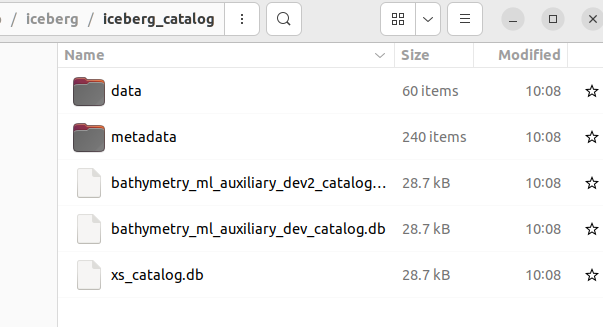